In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/NASA_Transfer_Learning/toy')
print("Current working directory: ", os.getcwd())

Current working directory:  /content/drive/MyDrive/Colab Notebooks/NASA_Transfer_Learning/toy


In [3]:
import sys

sys.path.append("/content/drive/MyDrive/Colab Notebooks/NASA_Transfer_Learning/") # Add root directory to PATH

In [11]:
from datetime import datetime
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# from datasets import mnist, mnist_m, svhn
from models.ganin import GaninModel
import trainers.ganin as trainer
# from trainers.ganin import train_ganin, test_ganin # getting called within /toy
from utils import transform, helper


# Set random seed to ensure deterministic behavior
helper.set_random_seed(seed=123)

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [5]:
# Install wandb ()

!pip install wandb --upgrade

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.25)


In [6]:
import wandb
wandb.login()

wandb: Currently logged in as: nisyad (use `wandb login --relogin` to force relogin)


True

In [8]:
# Hyperparameters 
config = dict(epochs=25,
              batch_size=32,
              learning_rate=2e-4,
              classes=10,
              img_size=28,
              dataset='mnist-mnist_m',
              architecture='ganin')


In [8]:
def get_data(dataset, data_dir):
    if dataset in ['mnist', 'mnist_m']:
        return torch.load(data_dir)

    elif dataset == 'svhn':
        svhn = io.loadmat(data_dir) # returns a dictionary
    
        return svhn

    elif dataset == 'usps':
        usps = pd.read_csv(data_dir)

        return usps

In [9]:
src_train = torch.load("../data/mnist/processed/train.pt")
src_test = torch.load("../data/mnist/processed/train.pt")


In [28]:
mnist_X = src_train[0] / 255
mnist_y = src_train[1]

print(mnist_X.shape)
print(mnist_y.shape)

print(mnist_X.dtype)
print(mnist_y.dtype)

print(mnist_X.max())
print(mnist_X.min())

print(mnist_y.max())
print(mnist_y.min())

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.float32
torch.int64
tensor(1.)
tensor(0.)
tensor(9)
tensor(0)


tensor(3)


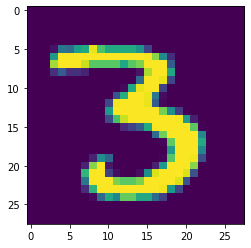

In [29]:
# sanity check - mnist

n = 12
print(mnist_y[n])
plt.imshow(mnist_X[n])

plt.show()

In [53]:
# Shuffle and pick subset

from sklearn.utils import shuffle

mnist_X, mnist_y = shuffle(mnist_X, mnist_y)

mnist_X_train = mnist_X[:7438].unsqueeze(1)
mnist_y_train = mnist_y[:7438]

mnist_X_test = mnist_X[7438:9298].unsqueeze(1)
mnist_y_test = mnist_y[7438:9298]



In [54]:
print(mnist_X_train.shape)
print(mnist_X_test.shape)

print(mnist_y_train.shape)
print(mnist_y_test.shape)


torch.Size([7438, 1, 28, 28])
torch.Size([1860, 1, 28, 28])
torch.Size([7438])
torch.Size([1860])


tensor(7)


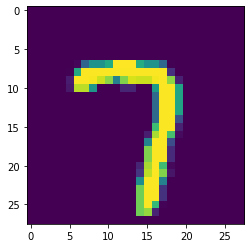

In [55]:
# sanity check 2.- mnist

n = 120
print(mnist_y_test[n])
plt.imshow(mnist_X_test[n].squeeze(0))

plt.show()

In [37]:
# Load USPS data

tgt_train = torch.load("../data/usps/processed/train.pt")
tgt_test = torch.load("../data/usps/processed/test.pt")

In [38]:
usps_X_train = tgt_train[0] 
usps_y_train = tgt_train[1]

usps_X_test = tgt_test[0] 
usps_y_test = tgt_test[1]


print(usps_X_train.shape)
print(usps_y_train.shape)

print(usps_X_train.dtype)
print(usps_y_train.dtype)

print(usps_X_train.max())
print(usps_X_train.min())
print(usps_y_train.max())
print(usps_y_train.min())

print("\n")

print(usps_X_test.shape)
print(usps_y_test.shape)

print(usps_X_test.dtype)
print(usps_y_test.dtype)

print(usps_X_test.max())
print(usps_X_test.min())
print(usps_y_test.max())
print(usps_y_test.min())


torch.Size([7438, 1, 28, 28])
torch.Size([7438])
torch.float32
torch.int32
tensor(1.0000)
tensor(0.)
tensor(9, dtype=torch.int32)
tensor(0, dtype=torch.int32)


torch.Size([1860, 1, 28, 28])
torch.Size([1860])
torch.float32
torch.int32
tensor(1.0000)
tensor(0.)
tensor(9, dtype=torch.int32)
tensor(0, dtype=torch.int32)


In [69]:
# Shuffle

usps_X_train, usps_y_train = shuffle(usps_X_train, usps_y_train)
usps_X_test, usps_y_test = shuffle(usps_X_test, usps_y_test)


In [71]:
print(usps_X_train.shape)
print(usps_X_test.shape)

print(usps_y_train.shape)
print(usps_y_test.shape)

torch.Size([7438, 1, 28, 28])
torch.Size([1860, 1, 28, 28])
torch.Size([7438])
torch.Size([1860])


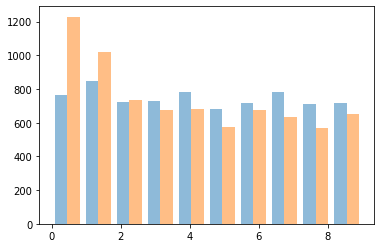

In [72]:
# sanity checks

import matplotlib.pyplot as plt

h1 = mnist_y_train.numpy()
h2 = usps_y_train.numpy()

plt.hist([h1, h2], alpha=0.5)

plt.show()

tensor(0, dtype=torch.int32)


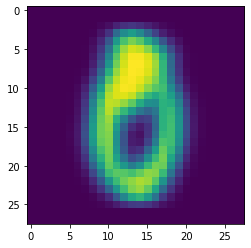

In [73]:
# sanity check - usps

n = 12
print(usps_y_test[n])
plt.imshow(usps_X_test[n].squeeze(0))

plt.show()

tensor(1, dtype=torch.int32)

In [78]:
import torch
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):

        
        self.data = data
        self.data = self.data.expand(-1, 3, -1, -1)  # [N,3,28,28]
        
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)  

    def __getitem__(self, idx):

        X = self.data[idx].float()
        y = self.labels[idx].long()

        if self.transform:
            X = self.transform(X)

        return X, y


# class USPSDataset(Dataset):
#     def __init__(self, data, labels, transform=None):

        
#         self.data = data
#         self.data = self.data.expand(-1, 3, -1, -1)  # [N,3,28,28]
        
#         self.labels = labels
#         self.transform = transform

#     def __len__(self):
#         return len(self.data)  

#     def __getitem__(self, idx):

#         X = self.data[idx].float()
#         y = self.labels[idx]

#         if self.transform:
#             X = self.transform(X)

#         return X, y





def fetch(data,
          labels,
          batch_size=64,
          transform=None,
          shuffle=True,
          num_workers=1,
          pin_memory=True):

    
    # if dataset == 'mnist'
    dataset = CustomDataset(data=data, labels=labels, transform=transform)

    # else:
    #     dataset = USPSDataset(data=data, labels=labels, transform=transform)

    return DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=num_workers,
                      pin_memory=pin_memory)


In [88]:
def main(hyperparameters):

    with wandb.init(project="uda-ganin-toy", config=hyperparameters, mode='disabled'):
        model = GaninModel().to(device)
        wandb.watch(model, log='all', log_freq=100)

        # transforms
        # transform_src = transform.get_transform(dataset="mnist")
        # transform_tgt = transform.get_transform(dataset="usps")

        transform_src = None
        transform_tgt = None


        # dataloaders
        loaders_args = dict(
            batch_size=config["batch_size"],
            shuffle=True,
            num_workers=1,
            pin_memory=True,
        )

        
        
        trainloader_tgt = fetch(data=mnist_X_train,
                                labels=mnist_y_train,
                                transform=transform_src,
                                **loaders_args)

      
        
        testloader_tgt = fetch(data=mnist_X_test,
                                labels=mnist_y_test,
                                transform=transform_src,
                                **loaders_args)

        
        
        trainloader_src = fetch(data=usps_X_train,
                                labels=usps_y_train,
                                transform=transform_tgt,
                                **loaders_args)


        
        
        testloader_src = fetch(data=usps_X_test,
                                labels=usps_y_test,
                                transform=transform_tgt,
                                **loaders_args)


        criterion_l = nn.CrossEntropyLoss() # class labels 1 to N class
        criterion_d = nn.BCEWithLogitsLoss() # domain 0/1
        optimizer = optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
        
        start_time = datetime.now()
        for epoch in range(1, config["epochs"]+1):
            
            loss = trainer.train_ganin(model, epoch, config, trainloader_src, trainloader_tgt,
                        criterion_l, criterion_d, optimizer, device)
            
            wandb.log({"epoch" : epoch, "train_loss" : loss}, step=epoch)

            accuracy = trainer.test_ganin(model, trainloader_tgt, device)

            wandb.log({"epoch" : epoch, "val_accuracy" : accuracy}, step=epoch)

        end_time = datetime.now()
        print(f"Train Time for {config['epochs']} epochs: {end_time - start_time}")

    return model


In [89]:
# Run

output = main(config)

alpha:  0.197375320224904


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch: 1/25 Batch: 30/233
Total Loss: 3.3280704021453857
Epoch: 1/25 Batch: 60/233
Total Loss: 3.086880683898926
Epoch: 1/25 Batch: 90/233
Total Loss: 2.9300589561462402
Epoch: 1/25 Batch: 120/233
Total Loss: 2.7880008220672607
Epoch: 1/25 Batch: 150/233
Total Loss: 2.673311233520508
Epoch: 1/25 Batch: 180/233
Total Loss: 2.58192777633667
Epoch: 1/25 Batch: 210/233
Total Loss: 2.5006966590881348
Test accuracy: 0.7111243605613708


alpha:  0.379948962255225
Epoch: 2/25 Batch: 30/233
Total Loss: 1.8849493265151978
Epoch: 2/25 Batch: 60/233
Total Loss: 1.858661413192749
Epoch: 2/25 Batch: 90/233
Total Loss: 1.8276466131210327
Epoch: 2/25 Batch: 120/233
Total Loss: 1.8028994798660278
Epoch: 2/25 Batch: 150/233
Total Loss: 1.7849555015563965
Epoch: 2/25 Batch: 180/233
Total Loss: 1.769602656364441
Epoch: 2/25 Batch: 210/233
Total Loss: 1.7577911615371704
Test accuracy: 0.7410522699356079


alpha:  0.5370495669980351
Epoch: 3/25 Batch: 30/233
Total Loss: 1.6407746076583862
Epoch: 3/25 Batch:

In [81]:
def test(model, testloader_tgt, device='cpu'):

    accuracy = 0
    model.eval()
    with torch.no_grad():
        
        for imgs, lbls in testloader_tgt:

            imgs, lbls = imgs.to(device), lbls.to(device)
            logits, _ = model(imgs, 0)  # alpha=0 for test
            # print("logits shape: ", logits.shape)

            # derive which class index corresponds to max value
            preds_l = torch.max(logits, dim=1)[1]
            # print("preds shape: ", preds_l.shape)
            # print("labels shape: ", lbls.shape)
            
            equals = torch.eq(preds_l,
                              lbls)  # count no. of correct class predictions
            accuracy += torch.mean(equals.float())

    print(f"Test accuracy: {accuracy / len(testloader_tgt)}")
    print("\n")

    return accuracy / len(testloader_tgt)

In [87]:
test(output, testloader_tgt, device)

Test accuracy: 0.8829449415206909




tensor(0.8829, device='cuda:0')

In [84]:
# transforms
transform_src = None
transform_tgt = None


# dataloaders
loaders_args = dict(
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)



trainloader_src = fetch(data=mnist_X_train,
                        labels=mnist_y_train,
                        transform=transform_src,
                        **loaders_args)



testloader_src = fetch(data=mnist_X_test,
                        labels=mnist_y_test,
                        transform=transform_src,
                        **loaders_args)



trainloader_tgt = fetch(data=usps_X_train,
                        labels=usps_y_train,
                        transform=transform_tgt,
                        **loaders_args)




testloader_tgt = fetch(data=usps_X_test,
                        labels=usps_y_test,
                        transform=transform_tgt,
                        **loaders_args)
